In [2]:
from lime import lime_image
import os
from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from skimage import transform

#Classify and output the validation generator and predictions
def classify(stain_dir):
    validation_dir = os.path.join(stain_dir, 'validation')
    test_datagen = ImageDataGenerator( rescale = 1.0/255. )
    validation_generator =  test_datagen.flow_from_directory( validation_dir, batch_size  = 10, class_mode  = 'binary', 
                                                              target_size = (200, 200),  shuffle=False)

    prediction = saved_model.predict(validation_generator)
    y_pred = np.matrix.flatten(prediction)
    Y_pred = np.around(y_pred, 0)

    print('Confusion Matrix')
    print(confusion_matrix(validation_generator.classes, Y_pred))

    target_names = ['ARMS', 'ERMS']
    print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))
    return (validation_generator, Y_pred, prediction)

#New load function for returning images to analyse
def new_load(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size = (200, 200, 3))
        img = image.img_to_array(img).astype('float32')/255
        img = transform.resize(img, (200, 200, 3))
        img = np.expand_dims(img, axis=0)
        out.append(img)
    return np.vstack(out)

In [3]:
#Loads a model

saved_model_md = tf.keras.models.load_model('Results/Saved Model - MYod1 .91')
#saved_model_myo = tf.keras.models.load_model('Results/Saved Model - myogenin .90')
#saved_model_he = tf.keras.models.load_model('Results/Saved Model - H&E')
#saved_model_tri = tf.keras.models.load_model('Results/Saved Model - trichrome')

In [5]:
#Assign model to in-use model for analysis/prediction

saved_model = saved_model_md

In [6]:
validation_generator, Y_pred, prediction = classify('RMS myod1/')

Found 143 images belonging to 2 classes.
Confusion Matrix
[[33  7]
 [ 6 97]]
              precision    recall  f1-score   support

        ARMS       0.85      0.82      0.84        40
        ERMS       0.93      0.94      0.94       103

    accuracy                           0.91       143
   macro avg       0.89      0.88      0.89       143
weighted avg       0.91      0.91      0.91       143



In [7]:
#Print predictions
print(Y_pred)

#Print actual results
print(validation_generator.classes)

[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [9]:
#Predict and output confidence intervals for a test directory
for filename in os.listdir('test images/'):  
    i = new_load([os.path.join("test images/", filename)])
    prediction = saved_model.predict(i)
    print(prediction)
    y_pred = np.matrix.flatten(prediction)
    Y_pred = np.around(y_pred, 0)
    print(Y_pred)
    

[[0.9996846]]
[1.]
[[0.97457993]]
[1.]
[[0.9421934]]
[1.]
[[0.9999964]]
[1.]
[[0.98680836]]
[1.]


Predicting ERMS with: 99.99964% confidence
0.9999964237213135
[1.]


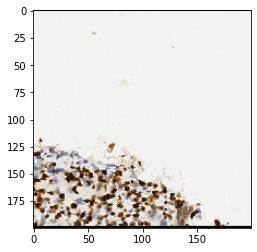

In [13]:
image_path = 'test images/myogenin.png'

images = new_load([image_path])
preds = saved_model.predict(images)

if (float(preds) < 0.5):
    print("Predicting ARMS with: " + str(round(100 - (float(preds) * 100 ), 5)) + "% confidence")
else:
    print("Predicting ERMS with: " + str(round( (float(preds) * 100 ), 5)) + "% confidence")
    
print(float(preds))

p = np.matrix.flatten(preds)
prediction_rounded = np.around(p, 0)

plt.imshow(images[0])
print(prediction_rounded)

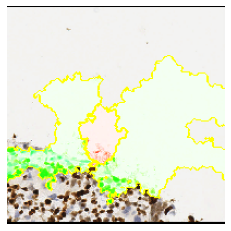

In [15]:
# Explanation for top class
image_path = 'test images/myogenin.png'

images = new_load([image_path])
preds = saved_model.predict(images)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), saved_model.predict, top_labels=5, 
                                         hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

plt.axis('off')
plt.imshow(mark_boundaries(temp, mask))
plt.savefig("myo.png", dpi=500, pad_inches=0, bbox_inches='tight')


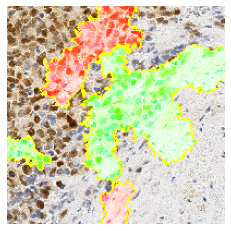

In [246]:
#Pros indicate the image is the class predicted
#Cons indicate the image is the other class
#(pros in green, cons in red)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

plt.axis('off')
plt.imshow(mark_boundaries(temp, mask))
plt.savefig("myo.png", dpi=500, pad_inches=0, bbox_inches='tight')

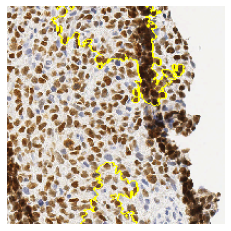

In [215]:
#Explanation with whole image present

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features= 5, hide_rest=False)
plt.axis('off')
plt.imshow(mark_boundaries(temp, mask))
plt.savefig("myod.png", dpi=200, pad_inches=0, bbox_inches='tight')

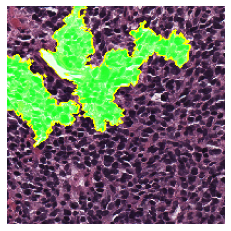

In [63]:
# Shows the pros and cons that have weight at least x, high rates are rare for MYoD1
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, 
                                            hide_rest=False, min_weight=0.022)

plt.axis('off')
plt.imshow(mark_boundaries(temp, mask))
plt.savefig("H&E .png", dpi=200, pad_inches=0, bbox_inches='tight')

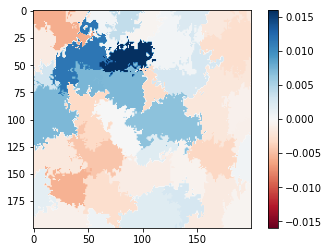

In [186]:
#plot explanation weights onto a heatmap visualization

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [20]:
import pickle
history = pickle.load(open( "results/Saved Model History - H&E Norm comp", "rb" ))
no_history = pickle.load(open( "results/Saved Model History - H&E No Norm comp", "rb" )) 

plt.rcParams["font.family"] = "Times New Roman"

auc      = history[     'auc' ]
val_auc  = history[ 'val_auc' ]
loss     = history[    'loss' ]
val_loss = history['val_loss' ]

no_auc      = no_history[     'auc' ]
no_val_auc  = no_history[ 'val_auc' ]
no_loss     = no_history[    'loss' ]
no_val_loss = no_history['val_loss' ]

epochs   = range(len(auc)) # No. of epochs

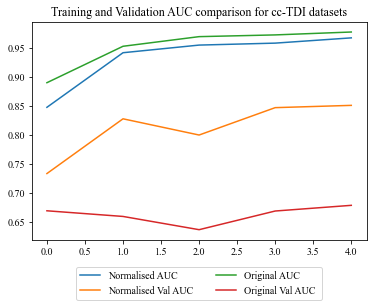

In [21]:
plt.plot  ( epochs,     auc, label = "Normalised AUC")
plt.plot  ( epochs, val_auc, label = "Normalised Val AUC " )
plt.plot  ( epochs, no_auc, label = "Original AUC " )
plt.plot  ( epochs, no_val_auc, label = "Original Val AUC " )
plt.title ('Training and Validation AUC comparison for cc-TDI datasets')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -.3), ncol= 2)
plt.savefig("AUC.png", dpi=500, bbox_inches='tight') 

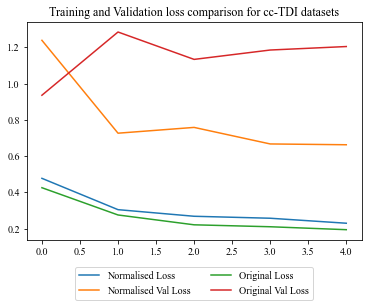

In [22]:
plt.plot  ( epochs,     loss, label = "Normalised Loss" )
plt.plot  ( epochs, val_loss, label = "Normalised Val Loss" )
plt.plot  ( epochs, no_loss, label = "Original Loss")
plt.plot  ( epochs, no_val_loss, label = "Original Val Loss")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -.3), ncol= 2)
plt.title ('Training and Validation loss comparison for cc-TDI datasets')
plt.savefig("Loss.png", dpi=500, bbox_inches='tight') 

<Figure size 432x288 with 0 Axes>

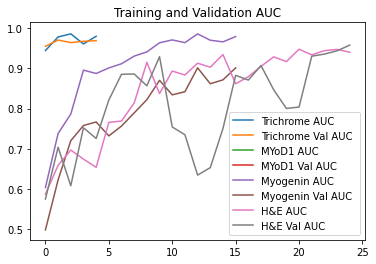

<Figure size 432x288 with 0 Axes>

In [17]:
tri_history = pickle.load(open( "results/Saved Model History - trichrome", "rb" )) 
md_history = pickle.load(open( "results/Saved Model History - MYoD1 .91", "rb" )) 
myo_history = pickle.load(open( "results/Saved Model History - Myogenin .90", "rb" )) 
he_history = pickle.load(open( "results/Saved Model History - H&E", "rb" )) 

tri_auc      = tri_history[     'auc' ]
tri_val_auc  = tri_history[ 'val_auc' ]
md_auc      = md_history[     'auc' ]
md_val_auc  = md_history[ 'val_auc' ]
myo_auc      = myo_history[     'auc' ]
myo_val_auc  = myo_history[ 'val_auc' ]
he_auc      = he_history[     'auc' ]
he_val_auc  = he_history[ 'val_auc' ]

tri_epochs   = range(len(tri_auc)) # No. of epochs
md_epochs   = range(len(md_auc)) # No. of epochs
myo_epochs   = range(len(myo_auc)) # No. of epochs
he_epochs   = range(len(he_auc)) # No. of epochs

plt.plot  ( tri_epochs,     tri_auc, label = "Trichrome AUC")
plt.plot  ( tri_epochs, tri_val_auc, label = "Trichrome Val AUC " )
plt.plot  ( md_epochs,     md_auc, label = "MYoD1 AUC")
plt.plot  ( md_epochs, md_val_auc, label = "MYoD1 Val AUC " )
plt.plot  ( myo_epochs,     myo_auc, label = "Myogenin AUC")
plt.plot  ( myo_epochs, myo_val_auc, label = "Myogenin Val AUC " )
plt.plot  ( he_epochs,     he_auc, label = "H&E AUC")
plt.plot  ( he_epochs, he_val_auc, label = "H&E Val AUC " )

plt.title ('Training and Validation AUC')
plt.legend(loc = 'lower right')
plt.figure()

In [33]:
print("AUC for Train Sets:")
print("H&E: " + str(max(he_auc)))
print("Trichrome: " + str(max(tri_auc)))
print("Myogenin: " + str(max(myo_auc)))
print("MYoD1: " + str(max(md_auc)))

print("\nAUC for Val. Sets:")
print("H&E: " + str(max(he_val_auc)))
print("Trichrome: " + str(max(tri_val_auc)))
print("Myogenin: " + str(max(myo_val_auc)))
print("MYoD1: " + str(max(md_val_auc)))


AUC for Train Sets:
H&E: 0.9476625323295593
Trichrome: 0.9858911633491516
Myogenin: 0.9858130216598511
MYoD1: 0.9899013042449951

AUC for Val. Sets:
H&E: 0.9578351974487305
Trichrome: 0.9704411625862122
Myogenin: 0.9013822078704834
MYoD1: 0.9547329545021057


In [23]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
dense (Dense)                (None, 4, 4, 1024)        1573888   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1